## Skysearch 
Here, we provide a description of the [skysearch](https://github.com/edwarddramirez/skysearch) repo what we intended to do with it. It applies the CWT across all patches and compiles those results together to obtain a full list of candidate point sources. This is all described in the `README.txt` file in that repo. One of the key notes is that the pipeline uses HTCondor to parallelize the search across each father pixel (spherical patch) by submitting scripts to CPUs in a CPU cluster. 

In the `README.txt` file, I describe the main steps of the pipeline. Each step corresponds to a specific script `.py` file and a possible set of HTCondor job submission scripts for parallelization. For example, consider Step 5:
```
5. Generate wavelet coefficients in the grid
    
    Code: generate_wavelet_coefficients.py [model] [trial_id] [energy_bin] [map_type] [npix] [grid_scale_deg] \\
                                           [wavelet_name] [a_deg] [inj_id]
                                           
        ... (Description of Code) ...
        ... (Description of Code) ...
        ... (Description of Code) ...

    Farm Instructions:
        1. python wt_makejob.py 
        2. cd wt_batch_exec
        3. source do_all.src
```
Therefore, we first describe the script that performs the task being described. Then, if applicable, we describe the steps to run these scripts as jobs in a CPU cluster via HTCondor.

In addition to finding point sources, the first files in the repo contain scripts that create synthetic *Fermi*-LAT $\gamma$-ray non-point source data and injecting point sources. Our code is written in a way that allows us to create and scan $\gamma$-ray maps in different energy bins.

## Purpose of Repo
We want to set limits on the point source luminosity function in the Galactic Center using a model of the statistics of the wavelets in the $\gamma$-ray sky. Here, we describe some of the progress towards that application.

## Active Branches
* `Features`: Add new features or improvements to the repo
* `Connection`: Find a connection between wavelet coefficient and number of photons that make up a point source

Some results from the `Connection` branch is shown in Slides 23 - 47 in the `extra/allsky_ps_detection/extra_slides.ppt` file. 

## Connection 
We empirically verified some results from [Damiani et al. (1997)](https://iopscience.iop.org/article/10.1086/304217/pdf).

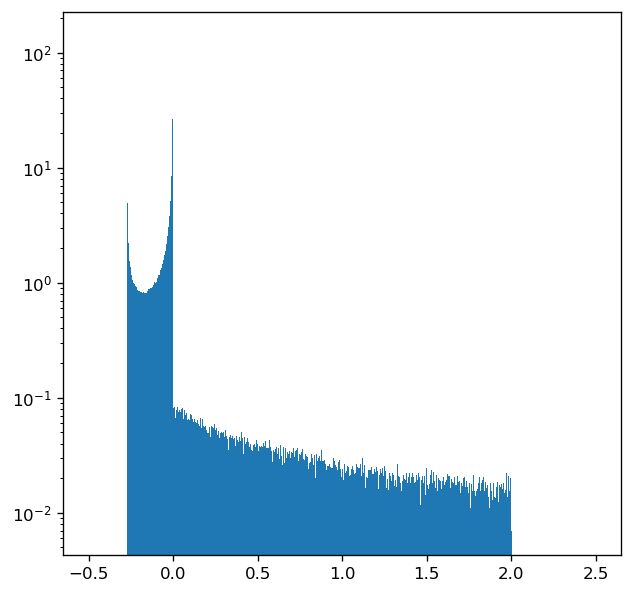 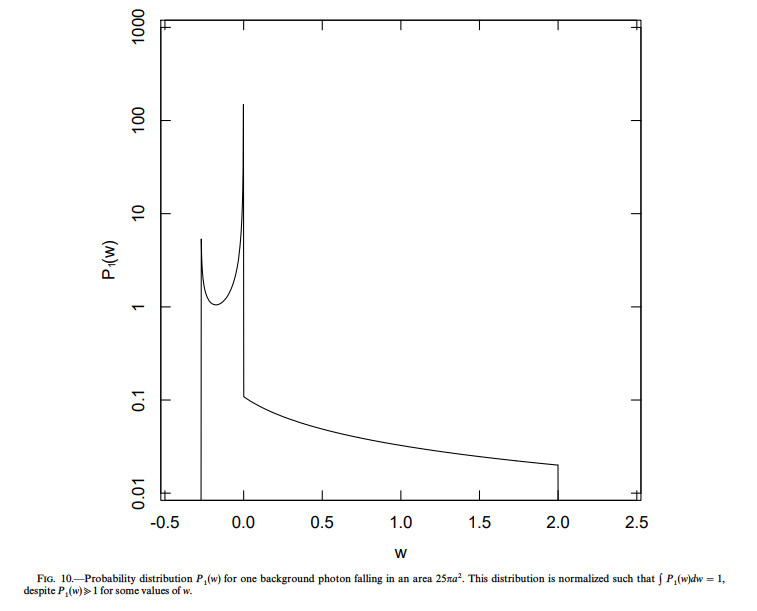

## Analytic Wavelet Transform for Realistic *Fermi*-LAT Point Source
One of Damiani's important results is giving an analytic expression for the CWT of a Gaussian Point Source. For 
$$ f(r) = \frac{N_{src}}{2 \pi \sigma^{2}_{src}} e^{-\frac{r^2}{2 \sigma_{src}^2}}, $$
its CWT is given by
$$
w(r, a)=\frac{N_{\mathrm{src}}}{\left(1+\sigma_{\mathrm{src}}^2 / a^2\right)^2}\left(2-\frac{r^2}{a^2+\sigma_{\mathrm{src}}^2}\right) e^{-r^2 / 2\left(a^2+\sigma_{\mathrm{sec}}{ }^2\right)},
$$
This result differs from ours by a constant factor due to a difference in convention.

For our use case, detecting *Fermi*-LAT sources, they do not obey a Gaussian distribution. 

## Fermi PSF
The Fermi-LAT cannot perfectly determine the direction $\hat{v}$ at which an incoming
photon emanated from. Instead, it will determine a reconstructed direction $\hat{v}' = \hat{v} + \delta v$, whose probability distribution is governed by the point-spread function (PSF), $P(\delta v | E, \hat{v})$. To scale out the energy-dependence from the PSF, one defines the *scaled angular deviation* $x$, given by
$$ x = \frac{\delta v}{S_{P}(E)}, $$
where the *scaling function* $S_{P}(E)$ is given by
\begin{equation}
    S_{P}(E) = \sqrt{\left ( c_0 \left ( \frac{E}{100 \ \rm MeV} \right )^{-\beta} \right )^{2} + c_1^2}.
\end{equation}
For FRONT events, the parameters $c_0 = 6.38 \times 10^{-2}$, $c_1 = 1.26 \times 10^{-3}$, and $\beta = 0.8 (see [Link](https://fermi.gsfc.nasa.gov/ssc/data/analysis/documentation/Cicerone/Cicerone_LAT_IRFs/IRF_PSF.html)). The PSF can then be written as $P(x |  \hat{v})$.

For the **P8R3_V2** dataset, the PSF is fit to the following function:
\begin{equation}
    P(x | E) = f_{\rm core}K(x,\sigma_{\rm core},\gamma_{\rm core}) + (1-f_{\rm core})K(x,\sigma_{\rm tail},\gamma_{\rm tail}),
\end{equation}
where the parameters $\{f_{\rm core}, \sigma_{\rm core}, \ldots \}$ are each functions of energy and $K$ is the King function, given by
\begin{equation}
    K(x,\sigma,\gamma) = \frac{1}{2\pi\sigma^2} \left ( 1 - \frac{1}{\gamma} \right ) \left ( 1+\frac{x^2}{2\gamma\sigma^2}\right )^{-\gamma}.
\end{equation}

## Wavelet Transform of Fermi Point Source
For the King Profile given by the equation above and the Mexican Hat wavelet of the first kind given in the first notebook, its continuous wavelet transform can be given by the following integral expression over the radius $b$:
\begin{equation}
    w(\vec{b},a) = \frac{(1-\gamma^{-1})}{\sigma^2 a} e^{-b^2 / 2a^2} \int_0^\infty dx \ x \left ( 1+\frac{x^2}{2 \sigma^2 \gamma} \right )^{-\gamma} e^{-x^2 / 2a^2} \left [ \left ( 2 - \frac{b^2}{a^2} - \frac{x^2}{a^2} \right )  I_0 \left ( \frac{bx}{a^2} \right ) + \frac{2bx}{a^2} I_1 \left ( \frac{bx}{a^2} \right ) \right ],
\end{equation}
where $I_0$ and $I_1$ are the modified Bessel functions of the zeroth and first kinds, respectively. We evaluate the function by performing a numerical integral via Gaussian quadrature (via Mathematica `NIntegrate`). Requiring a computer to solve this integral directly through Gaussian quadrature fails due to the exponentially increasing values of the modified Bessel functions. Therefore, when $b x / a^2$ exceeds some high enough value before the algorithm fails, we replace the modified Bessel functions with their asymptotic expansions (see [1](https://math.stackexchange.com/questions/2791588/leading-terms-in-asymptotic-expansion-of-modified-bessel-function-of-the-first-k), [2](https://functions.wolfram.com/Bessel-TypeFunctions/BesselI/06/02/01/01/01/0001/), or Gradsteyn 8.451.5 for more details):
\begin{equation}
    I_{0}(x) \sim \frac{e^{x}}{\sqrt{2\pi x}} \left ( 1 + \frac{1}{8x} \right ) \ ; \ 
    I_{1}(x) \sim \frac{e^{x}}{\sqrt{2\pi x}} \left ( 1 - \frac{3}{8x} \right )
\end{equation}
Therefore, we can rewrite the integral as 
\begin{align}
    w(\vec{b},a) & \sim \frac{(1-\gamma^{-1})}{\sigma^2 a} \biggl \{ \biggr. e^{-b^2 / 2a^2} \int_0^R dx \ x \left ( 1+\frac{x^2}{2 \sigma^2 \gamma} \right )^{-\gamma} e^{-x^2 / 2a^2} \left [ \left ( 2 - \frac{b^2}{a^2} - \frac{x^2}{a^2} \right )  I_0 \left ( \frac{bx}{a^2} \right ) + \frac{2bx}{a^2} I_1 \left ( \frac{bx}{a^2} \right ) \right ] + \\
    & + \int_R^\infty dx \ x \left ( \frac{a}{\sqrt{2\pi b x}} \right ) \left ( 1+\frac{x^2}{2 \sigma^2 \gamma} \right )^{-\gamma} e^{-(x-b)^2 / 2a^2} \left [ \left ( 2 - \frac{b^2}{a^2} - \frac{x^2}{a^2} \right )  
    \left ( 1 + \frac{1}{8} \frac{a^2}{b x} \right ) + \frac{2bx}{a^2} \left ( 1 - \frac{3}{8} \frac{a^2}{b x} \right ) \right ] \biggl. \biggr \}  ,
\end{align}
where $R$ represents the value at which we begin replacing the true integrand with its asymptotic approximation.

This would be enough if $\vec{x}$ denotes the raw angular deviation. However, the PSF is in terms of the scaled angular deviation above. Therefore, the King distribution in terms of the raw angular deviation is given by
\begin{equation}
    P_{r}(r) = P_{x}(x(r)) \frac{dx}{dr} = \frac{1}{S_{P}(E)} \ P_{x}(r/S_{P}(E))
\end{equation}
Therefore, the only modification to the wavelet expression above is to make is in the King Profile term by replacing $x \rightarrow x / S_{P}(E)$ and divide the entire expression by $S_{P}(E)$. Thus,
\begin{align}
    w(\vec{b},a) & = \frac{1}{S_{P}(E)} \frac{(1-\gamma^{-1})}{\sigma^2 a} e^{-b^2 / 2a^2} \times \\
    & \times \int_0^\infty dx \ x \left ( 1+\frac{x^2 / S_{P}^2(E)}{2 \sigma^2 \gamma } \right )^{-\gamma} e^{-x^2 / 2a^2} \left [ \left ( 2 - \frac{b^2}{a^2} - \frac{x^2}{a^2} \right )  I_0 \left ( \frac{bx}{a^2} \right ) + \frac{2bx}{a^2} I_1 \left ( \frac{bx}{a^2} \right ) \right ],
\end{align}
Since the major issues with the Gaussian quadrature were related to the modified Bessel functions, the algorithm should have no problem computing this modified integral.

## Creating Synthetic Point Sources
We will have to sample from the King Profile rather than a Gaussian. See **Appendix D** in `extra/allsky_ps_detection/fermi_app.pdf` for more details. An implementation is given in the same repository. Sampling in the sphere is already committed in the `Features` branch.
